In [98]:
from SimPEG import Mesh, Utils, Maps
import simpegSP as SP
from pymatsolver import PardisoSolver
%pylab inline

Populating the interactive namespace from numpy and matplotlib


/Users/sgkang/anaconda2/lib/python2.7/site-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['f']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [99]:
dx = 10.
hxind = [(dx, 3, -1.3), (dx, 20), (dx, 3, 1.3)]
hyind = [(dx, 3, -1.3), (dx, 20), (dx, 3, 1.3)]
hzind = [(dx, 3, -1.3), (dx, 15), (dx/2., 5)]
mesh = Mesh.TensorMesh([hxind, hyind, hzind], "CCN")
sigma = np.ones(mesh.nC)*1./100.
actind = mesh.gridCC[:,2] < -0.2
actMap = Maps.InjectActiveCells(mesh, actind, 0.)

In [100]:
x = mesh.vectorCCx[np.logical_and(mesh.vectorCCx>-80, mesh.vectorCCx<80.)]
y = mesh.vectorCCy[np.logical_and(mesh.vectorCCy>-80, mesh.vectorCCy<80.)]
# xyzM = Utils.ndgrid(np.ones_like(x)*-80, np.ones_like(y)*-80, np.r_[0.])
xyzM = Utils.ndgrid(x+dx, y, np.r_[0.])
xyzN = Utils.ndgrid(x, y, np.r_[0.])

In [101]:
prb = SP.Problem_CC(mesh, sigma=sigma, jsMap=Maps.IdentityMap(nP=mesh.nC*3), Solver=PardisoSolver)
rx = SP.Rx.Dipole(xyzN, xyzM)
src = SP.Src.StreamingCurrents([rx], L=np.ones(mesh.nC), mesh=mesh, modelType="CurrentDensity")
survey = SP.Survey([src])
survey.pair(prb)

In [102]:
p0 = np.r_[-50, -10., -50.]
p1 = np.r_[50, 10., -100.]
inds = Utils.ModelBuilder.getIndicesBlock(p0, p1, mesh.gridCC)
jsx = np.zeros(mesh.nC)
jsy = np.zeros(mesh.nC)
jsz = np.zeros(mesh.nC)
jsx[inds] = 1.
jsCC = np.r_[jsx, jsy, jsz]

In [103]:
# mesh.plotSlice(jsx, normal="Y")

In [104]:
q = np.zeros(mesh.nC)
inda = Utils.closestPoints(mesh, np.r_[-80, 0., -40])
indb = Utils.closestPoints(mesh, np.r_[80, 0.,  -40])
indc = Utils.closestPoints(mesh, np.r_[0, -80., -40])
indd = Utils.closestPoints(mesh, np.r_[0, 80,  -40])

q[inda] = 1.
q[indb] = -1.
q[indc] = 1.
q[indd] = -1.
f = prb.fields(jsCC)
out = survey.dpred(jsCC, f=f)

In [105]:
# v = np.ones(mesh.nC)[actind]
# jvec = prb.Jvec(q[actind], q[actind])
# jtvec = prb.Jtvec(q[actind], np.ones_like(out))

In [106]:
# mesh.plotSlice(actMap*jtvec, normal="Z", ind=5)

(<matplotlib.collections.QuadMesh at 0x1805e6f50>,)

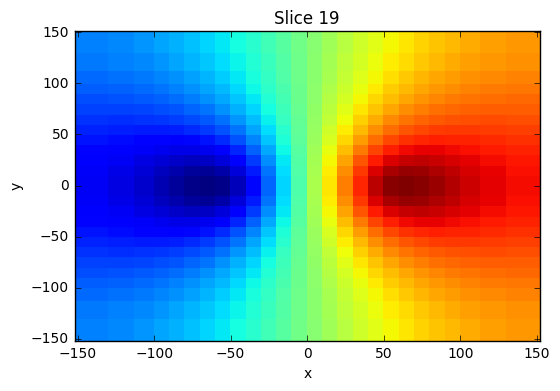

In [107]:
mesh.plotSlice(f[src, 'phi'], normal="Z", ind=19)

In [108]:
# Utils.plot2Ddata(xyzN[:,:2], dobs, scale="linear")
# # plt.plot(mesh.gridCC[inda,0], mesh.gridCC[inda,1], 'ko')
# # plt.plot(mesh.gridCC[indb,0], mesh.gridCC[indb,1], 'ro')

In [109]:
# hout = hist(np.log10(abs(dobs)),bins=100)

In [110]:
# print abs(dobs).min()
# print abs(dobs).max()*0.01

In [111]:
depthweight = 1./ ((abs(mesh.gridCC[:,2])+2.5)**3.)
depthweight /= depthweight.max()

In [112]:
# # Generate Full sensitivity
# I = np.diag(np.ones_like(dobs))
# J = np.zeros((dobs.size, mesh.nC))
# for i in range(dobs.size):
#     J[i,:] = prb.Jtvec(sigma, I[:,i])
#     JtJ = (J**2).sum(axis=0)
# JtJ /= JtJ.max()
# prb.G = J

In [113]:
# out = mesh.plotSlice(JtJ, normal="Y", ind=12)
# plt.colorbar(out[0])

In [114]:
# plt.plot(1./dmisfit.Wd.diagonal())

In [115]:
from SimPEG.EM.Static.SIP.Regularization import MultiRegularization

In [116]:
dobs = survey.dpred(jsCC)
dobs+= np.random.randn(survey.nD)*abs(dobs).max() * 0.05

In [117]:
mesh.nC*3

46644

In [118]:
jsCC.shape

(46644,)

In [128]:
from SimPEG import (Mesh, Maps, Utils, DataMisfit, Regularization,
                    Optimization, Inversion, InvProblem, Directives)
survey.std = 0.
survey.eps = abs(dobs).max() * 0.03
survey.dobs = dobs
 
dmisfit = DataMisfit.l2_DataMisfit(survey)
regmap = Maps.IdentityMap(nP = mesh.nC*3)
reg = MultiRegularization(mesh, mapping=regmap ,nModels=3)
reg.cell_weights = depthweight
reg.alpha_s = 1.
reg.alpha_x = 0.
reg.alpha_y = 0.
reg.alpha_z = 0.
opt = Optimization.ProjectedGNCG(maxIter=100, tolX=1e-20, tolF=1e-20)
opt.maxIterLS = 20
IRLS = Directives.Update_IRLS(norms=([0.,1.,1.,1.]),
                                     eps=None, f_min_change=1e-3,
                                     minGNiter=3)
# senseweight = Directives.Update_Wj()
invProb = InvProblem.BaseInvProblem(dmisfit, reg, opt)
target = Directives.TargetMisfit()
# Create an inversion object
beta = Directives.BetaSchedule(coolingFactor=5, coolingRate=3)
betaest = Directives.BetaEstimate_ByEig()
betaest.beta0_ratio = 2.
# updateprecond = Directives.Update_lin_PreCond()
# inv = Inversion.BaseInversion(invProb, directiveList=[betaest, updateprecond, IRLS])
inv = Inversion.BaseInversion(invProb, directiveList=[beta, betaest, target])
prb.counter = opt.counter = Utils.Counter()
opt.LSshorten = 0.5
opt.remember('xc')
m0 = np.ones(mesh.nC*3)*0.
reg.mref = m0
mopt = inv.run(m0)

SimPEG.InvProblem is setting bfgsH0 to the inverse of the eval2Deriv.
                    ***Done using same Solver and solverOpts as the problem***
model has any nan: 0
=============================== Projected GNCG ===============================
  #     beta     phi_d     phi_m       f      |proj(x-g)-x|  LS    Comment   
-----------------------------------------------------------------------------
x0 has any nan: 0
   0  1.12e+00  3.74e+04  0.00e+00  3.74e+04    1.46e+05      0              
   1  1.12e+00  7.24e+02  2.21e+01  7.48e+02    1.07e+04      0              
   2  1.12e+00  1.68e+02  3.13e+01  2.03e+02    6.17e+03      0              
   3  2.23e-01  1.38e+02  3.12e+01  1.44e+02    5.80e+03      0              
   4  2.23e-01  1.33e+02  3.27e+01  1.40e+02    6.02e+03      0              
------------------------- STOP! -------------------------
1 : |fc-fOld| = 0.0000e+00 <= tolF*(1+|f0|) = 3.7377e-16
0 : |xc-x_last| = 5.9765e-02 <= tolX*(1+|x0|) = 1.0000e-20
0 : |proj(x-g

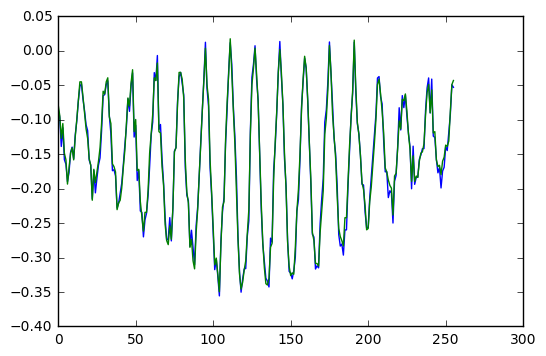

In [129]:
plt.plot(dobs)
plt.plot(invProb.dpred)

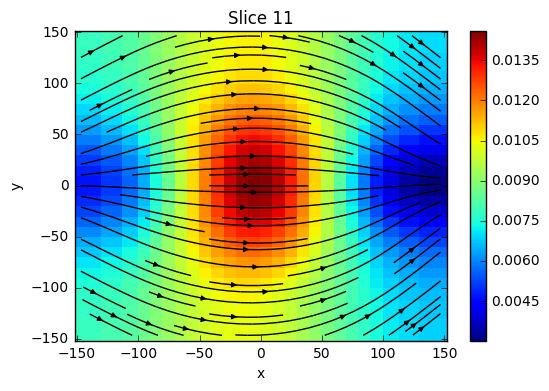

In [130]:
out = mesh.plotSlice(mopt, view='vec', vType="CCv")
plt.colorbar(out[0])

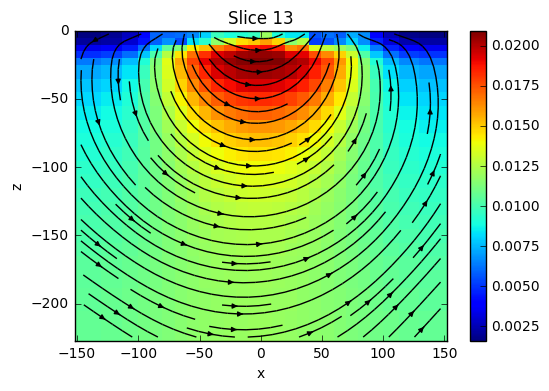

In [131]:
out = mesh.plotSlice(mopt, view='vec', vType="CCv", normal="Y")
plt.colorbar(out[0])

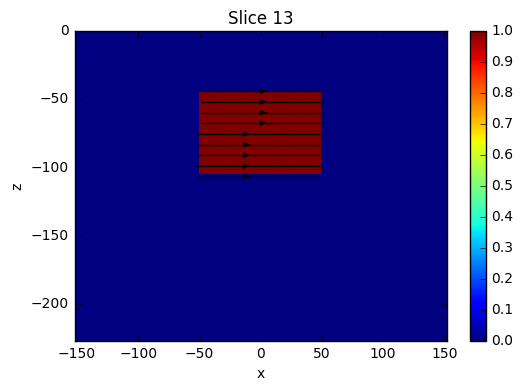

In [132]:
out = mesh.plotSlice(jsCC, view='vec', vType="CCv", normal="Y")
plt.colorbar(out[0])

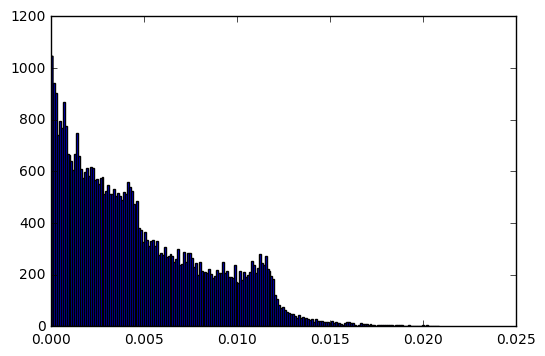

In [135]:
hout = hist(abs(mopt), bins=200)
# plt.xlim(0, 0.008)
plt.xscale("linear")

(<matplotlib.contour.QuadContourSet at 0x18ca3bd50>,
 <matplotlib.axes._subplots.AxesSubplot at 0x19d738d90>)

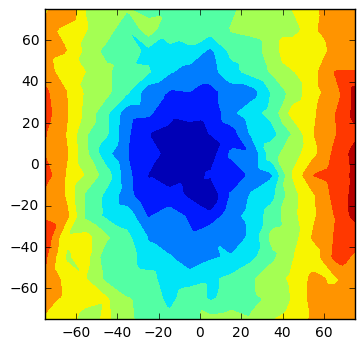

In [136]:
Utils.plot2Ddata(xyzN[:,:2], survey.dobs, scale="linear")

(<matplotlib.contour.QuadContourSet at 0x1943a54d0>,
 <matplotlib.axes._subplots.AxesSubplot at 0x19e0633d0>)

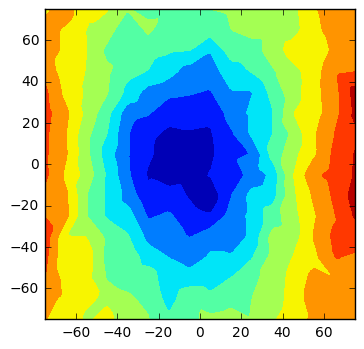

In [137]:
Utils.plot2Ddata(xyzN[:,:2], invProb.dpred, scale="linear")